In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rlmtp.downsampler import add_to_elastic, stress_strain_peaks, apply_downsampler, keep_upto_saturation
from rlmtp.downsampler import apply_removal_ranges, add_to_elastic, filter_stress
from rlmtp.downsampler import max_deviation_downsampler, perp_dist, max_dist

plt.rcParams.update({"text.usetex": False, "font.family": "sans-serif"})

%matplotlib inline

In [2]:
# Inputs
data = pd.read_csv('HEM320_C_LP8.csv')
max_dev_tol = 0.001
last_ind = None
removal_ranges = []
f_yn = 355.0
sat_tol = 0.99
n_cycles_min = 20
apply_filter = True
wl_base_factor = 5
wl_2prct_factor = 11
use_midpoint_method = False
n_elastic_region = 7

# Copied from rlmtp_downsampler
ind_ss, ind_2prct = stress_strain_peaks(data, last_ind=last_ind, f_yn=f_yn)

# Only use cycles up to saturation for constant amplitude tests
# Constant amplitude if ind_2prct=None and many peaks found
large_num_cycles = 55
if ind_2prct is None and len(ind_ss) > large_num_cycles and sat_tol is not None:
    ind_ss = keep_upto_saturation(data, ind_ss, sat_tol=sat_tol, n_cycles_min=n_cycles_min)

# Run max deviation downsampler
# Remove noise in the stress with a moving average filter
d = np.array(data[['e_true', 'Sigma_true']])
if apply_filter:
    d[:, 1] = filter_stress(d, ind_2prct, wl_base=wl_base_factor, wl_factor=wl_2prct_factor)
ind_downsampler = apply_downsampler(d, ind_ss[-1], max_dev_tol, use_midpoint_method=use_midpoint_method)

# Combine the points, remove any points that lie between the removal ranges
ind_final = ind_ss + ind_downsampler
ind_final = apply_removal_ranges(ind_final, removal_ranges)
# Remove any duplicates and sort
ind_final = sorted(list(set(ind_final)))

# Keep extra points in initial elastic region
ind_elastic = add_to_elastic(d, [ind_final[0], ind_final[1]], n_elastic_region)

# Sort again and return
ind_final += ind_elastic
ind_final = sorted(list(set(ind_final)))

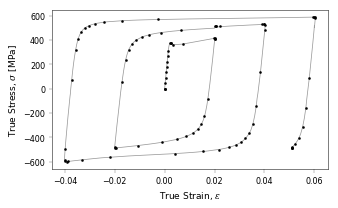

In [60]:
# Plot the overall results
e = data['e_true']
s = data['Sigma_true']
plt.figure(figsize=(4.8, 3))
plt.plot(e, s, c='0.6', lw=0.75, label='Test')
plt.plot(e.loc[ind_ss], s.loc[ind_ss], 'o', c='k', ms=2.0, label='Peaks')
plt.plot(e.loc[ind_downsampler], s.loc[ind_downsampler], 'o', c='k', ms=2.0, label='Max Dev. DS')
plt.plot(e.loc[ind_elastic], s.loc[ind_elastic], 'o', c='k', ms=2.0, label='Elastic')
plt.xlabel(r'True Strain, $\varepsilon$')
plt.ylabel(r'True Stress, $\sigma$ [MPa]')
# plt.legend()
plt.tight_layout()
plt.savefig('HEM320_C_LP8_inds.pdf')

In [4]:
# Zoom on one area to show the max dev downsampler
set(sorted(ind_ss))

{0, 699, 1888, 1893, 4567, 7237, 7286, 7617, 7914, 8433}

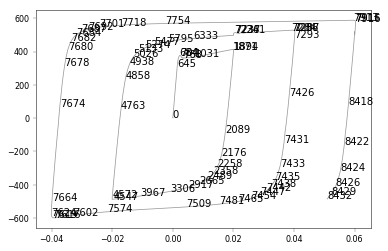

In [8]:
plt.figure()
plt.plot(e, s, c='0.6', lw=0.75, label='Test')
for i in ind_downsampler:
    plt.text(e.loc[i], s.loc[i], '{0}'.format(i))

In [39]:
def pos_on_line(xi, xj, xk):
    """ start xi, end xj, point xk. """
    s = xj - xi
    v = xk - xi
    p = np.dot(v, s) / np.dot(s, s) * s + xi
    return p

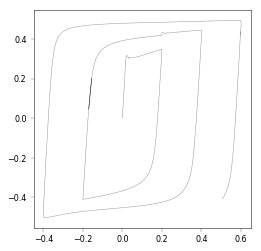

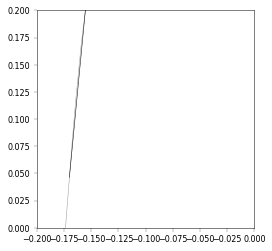

In [57]:
i1 = 4763
i2 = 4858
i3 = 4938


e2 = e / (e.max() - e.min())
s2 = s / (s.max() - s.min())

plt.figure()
# plt.plot(e2, s2, c='0.6', lw=0.75, label='Test')
plt.plot(e2, s2, c='0.6', lw=0.5, label='Test')
plt.plot(e2.loc[[i1, i2]], s2.loc[[i1, i2]], c='k', lw=0.5)
xi = np.array([e2.loc[i1], s2.loc[i1]])
xj = np.array([e2.loc[i2], s2.loc[i2]])
# for i in range(i1, i2, 10):
#     xk = np.array([e2.loc[i], s2.loc[i]])
#     xk_proj = pos_on_line(xi, xj, xk)
#     plt.plot([xk[0], xk_proj[0]], [xk[1], xk_proj[1]], 'k--', lw=0.3)


pos = np.column_stack((e2, s2))
n0 = i1
n1 = i2
imax = np.array([perp_dist(pos[n0, :], pos[n2, :], pos[n1, :]) for n2 in range(n0, n1)]).argmax()

xk = np.array([e2.loc[i1+imax], s2.loc[i1+imax]])
xk_proj = pos_on_line(xi, xj, xk)
plt.plot([xk[0], xk_proj[0]], [xk[1], xk_proj[1]], 'r--', lw=0.3)
plt.gca().set_aspect('equal')

plt.figure()

plt.plot(e2, s2, c='0.6', lw=0.5, label='Test')
plt.plot(e2.loc[[i1, i2]], s2.loc[[i1, i2]], c='k', lw=0.5)
plt.plot([xk[0], xk_proj[0]], [xk[1], xk_proj[1]], 'r--', lw=0.3)

plt.xlim([-0.2, 0.0])
plt.ylim([0.0, 0.2])
plt.gca().set_aspect('equal')
